In [3]:
# Yile Shen
# 3/7/2024
# Advanced Programming: AIML
# Osu playing robot

# Load in relevant libraries, and alias where appropriate
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
import math

from tqdm import tqdm

# couple notes: i chose to switch to pytorch as I was more comfortable with it
# and I needed to customize my model in a lot of ways, and I couldn't
# adequately get tensorflow to work.

# I also already had a really good setup for pytorch and I spent more time
# tuning the gpu usage on tensorflow. Pytorch also saved WAY more memory overall.

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True

# print name
print(torch.cuda.get_device_name(device))

# i had a tensorflow version, but I couldn't get some things to work in it
# so I switched to pytorch because I'm more comfortable with it and can do more.

#process images here so I can change resolution whenever
#
# FOLDER_PATH = "C:/Users/Yile0/PycharmProjects/osutime/frames/"
#
# for i in range(14, 5379):
#     img = cv2.imread(FOLDER_PATH + str(i)+".png")
#     img = cv2.resize(img, (160, 120), interpolation=cv2.INTER_AREA)
#     cv2.imwrite(FOLDER_PATH + str(i)+".png", img)
# making a custom image dataset class for pytorch
# originally had a custom dataset maker, but the dataloader is way better
# and formats them better.



NVIDIA GeForce RTX 4070


In [4]:
# compile dataset.
dataset_path = "C:/Users/Yile0/PycharmProjects/osutime/map1_data.csv"
data = pd.read_csv(dataset_path)

print(data.head())
print(data.columns)
# small data for changing, basically just for trialing new changes.
small_data = sklearn.utils.resample(data, n_samples= 1000)

# frame 4 is the latest/ most recent.

#originally these were one piece, changed for the dataloader to function
processed_data = []
processed_labels = []


def process_img(paths):
    # I had another self-made thing here that I decided to replace with premade functions
    images = []
    transform = transforms.Compose([transforms.ToTensor()])
    for path in paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        # 100 by 75 because slightly better quality
        # over 80 by 60
        img = cv2.resize(img, (120, 68), interpolation=cv2.INTER_AREA)
        img_normalized = cv2.normalize(img, None, 0, 1.0,
                                       cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        images.append(transform(img_normalized))
    out = torch.stack(images)
    # i played with trying to reshape to 120 16, but I came back
    # to this resolution because it was just so much better and faster
    # with regards to my training speed.
    out = out.reshape(len(paths),68,120)
    # played with preloading here and loading later, seems like loading later is better.
    # img = torch.from_numpy(img)
    return out


for index, row in tqdm(data.iterrows()):
    # trying without normalization.
    processed_labels.append([row['x'], row['y']])
    # try to predict just on 1 frame for testing
    processed_data.append(process_img([row['frame 4'],row['frame 3'],row['frame 2'],row['frame 1']]))


X_train, X_test, y_train, y_test = train_test_split(processed_data, processed_labels, test_size=0.1, random_state=42)

          x         y                                            frame 4  \
0  253.3333  256.4445  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
1  253.3333  256.0000  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
2  252.8889  256.0000  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
3  252.8889  256.0000  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
4  252.8889  256.0000  C:/Users/Yile0/PycharmProjects/osutime/frames/...   

                                             frame 3  \
0  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
1  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
2  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
3  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
4  C:/Users/Yile0/PycharmProjects/osutime/frames/...   

                                             frame 2  \
0  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
1  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
2  C:/Users/Yile0/PycharmProjects/osut

8930it [01:52, 79.57it/s]


In [5]:
class ImageDataset(Dataset):
    def __init__(self, images, labels, imageTransform=None, num_workers=0):
        self.imageTransform = imageTransform
        self.num_workers = num_workers
        self.imgs = images
        self.targets = labels

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        image = self.imgs[idx]
        target = self.targets[idx]
        label = torch.Tensor(target)

        return image, label

In [6]:
# Creating a CNN class
# conv neural net combined was bad, this iteration separates them
class ConvNeuralNet(nn.Module):
    #  Determine what layers and their order in CNN object
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        # adjusted the first pooling to be 4 instead.
        # tried second pooling to be 4 too

        self.conv_layer1 = nn.Conv2d(in_channels=4, out_channels=512, kernel_size=4)
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_layer2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=4)
        self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv_layer3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=4)
        self.max_pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_layer4 = nn.Conv2d(in_channels=512, out_channels=64, kernel_size=4)
        self.max_pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
        self.fc1 = nn.Linear(256, 128)
        # originally tried relu layers, but wanted something non-linear
        # went back because elu wasn't doing better
        # had 3 layers to begin with, then tried 4, then tried 7
        # I one off tried 13 but it didn't fit.=
        self.fc2 = nn.Linear(128,128)
        self.fc3 = nn.Linear(128, 1)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, 1)
        # self.relu7 = nn.ReLU()
        # self.fc8 = nn.Linear(75, 1)
        # self.relu8 = nn.ReLU()
        # self.fc9 = nn.Linear(25, 1)
        # self.relu9 = nn.ReLU()
        # self.fc10 = nn.Linear(50, 1)
    # Progresses data across layers
    def forward(self, input):
        out_x = self.conv_layer1(input)
        out_x = self.relu(out_x)
        out_x = self.max_pool1(out_x)
        out_x = self.conv_layer2(out_x)
        out_x = self.relu(out_x)
        out_x = self.max_pool2(out_x)

        out_x = self.conv_layer3(out_x)
        out_x = self.relu(out_x)
        out_x = self.max_pool3(out_x)
        out_x = self.conv_layer4(out_x)
        out_x = self.relu(out_x)
        out_x = self.max_pool4(out_x)

        out_x = out_x.reshape(out_x.size(0), -1)
        
        out_x = self.fc1(out_x)
        out_x = self.sigmoid(out_x)
        out_x = self.fc2(out_x)
        out_x = self.sigmoid(out_x)
        out_x = self.fc3(out_x)
        out_x = self.sigmoid(out_x)
        # out_x = self.relu(out_x)
        # out_x = self.relu(out_x)
        # out_x = self.relu(out_x)

        return out_x

In [7]:
# Define relevant variables for the ML task
# tried batch sizes of 32 and 128 as well, but this was best
# 128 had better cuda utilization but didn't boost speed too much.
# decided it was more worth it to have better accuracy because 128 could
# introduce inaccuracies.
# after adding a few new layers 64 wasn't enough to have fast epochs
# so I decided to move to 128.
# accidentally tried batch size of 1, was way too inefficient
batch_size = 80
# originally learning rate was 0.001, but im making it learn longer and slower.
# makes me wonder if my original idea would have worked, but now it's too late to fix it.
# 0.001 basically didn't learn. I trained for somwhere around 500 epochs and loss basiclly didn't change
# from now on, I ran some 20 epoch experiments.
# 0.0001 was learning a lot to start, but loss seems to cycle between 0.10 and 0.13 or so

# 0.00001 had loss settle at around 0.28/0.3, which is maybe due to the lack of time it had to train.
# loss was generally going down even at 50 epochs, can't tell without a longer experiment.
# i'm going to keep it at this and train for 100 and see what happens.
# doesn't seem to improve past loss = 0.11

# running a 400 epoch experiment with learning rate 0.000001
learning_rate = 0.00001
# ran a few experiments on 20 epochs to see if it would learn.
num_epochs = 125
device = "cuda"

In [8]:
dataset = ImageDataset(X_test, y_train)
test = ImageDataset(X_test, y_test)

# added workers to speedup epoch time.
# 3 is the max tolerable it seems.
data_loader = DataLoader(dataset, batch_size=batch_size)


# model = ConvNeuralNet(2, train_data.shape[0])

# Set Loss function with criterion

model_x = ConvNeuralNet(2)
model_x.cuda(device)
# adam is just better, tried other optimizers like sgd though
optimizer_x = torch.optim.Adam(model_x.parameters(), lr=learning_rate)

model_y = ConvNeuralNet(2)
model_y.cuda(device)
# adam is just better, tried other optimizers like sgd though

optimizer_y = torch.optim.Adam(model_y.parameters(), lr=learning_rate)
# MSE loss instead of L1, which is squared loss vs linear loss.
# Huber over both, has the benefits of both.
criterion = nn.MSELoss()
epoch_start = 0


epoch_start = 0
# added code that allows it to train again from a checkpoint
# it lets me train in chunks over time.
# checkpoint = torch.load('model.pth')
# model_x.load_state_dict(checkpoint['model_x_state_dict'])
# optimizer_x.load_state_dict(checkpoint['optimizer_x_state_dict'])
# model_y.load_state_dict(checkpoint['model_y_state_dict'])
# optimizer_y.load_state_dict(checkpoint['optimizer_y_state_dict'])
# epoch_start = checkpoint['epoch']
# loss = checkpoint['loss']

# Set optimizer with optimizer

total_step = len(processed_data)

model_x.train()
model_y.train()

losses_x = []
losses_y = []
losses_val_x = []
losses_val_y = []

lr_y = []
lr_x = []

In [17]:
import gc
def main():
    gc.collect()
    torch.cuda.empty_cache()
    for epoch in range(epoch_start, num_epochs):
        start = time.time()
        model_x.train()
        model_y.train()
        # Load in the data in batches using the train_loader object
        for i, (images, labels) in enumerate(tqdm(data_loader, desc = "Epoch " + str(epoch+1), miniters=10)):
            images = images.cuda(device)
            # Move tensors to the configured device
            # images already got loaded on
            # images = images.to(device)
            labels = labels.cuda(device)
            x_labels = labels[:, 0].unsqueeze(1)
            x_labels.requires_grad = True
            x_labels = x_labels.cuda(device)
            y_labels = labels[:, 1].unsqueeze(1)
            y_labels.requires_grad = True
            y_labels = y_labels.cuda(device)
            # Forward pass
            output_x = model_x(images) * 512
            loss_x = criterion(output_x, x_labels)
            output_y = model_y(images) * 384
            loss_y = criterion(output_y, y_labels)
            # Backward and optimize
            optimizer_y.zero_grad()
            optimizer_x.zero_grad()
            # had tried to combined, but now i'm just completely
            # separating the two models.
            loss_x.backward()
            loss_y.backward()
            optimizer_y.step()
            optimizer_x.step()
        # added checkpoint saver
        if (epoch + 1) % 6 == 0:
            torch.save({
                'epoch': epoch,
                'model_x_state_dict': model_x.state_dict(),
                'optimizer_x_state_dict': optimizer_x.state_dict(),
                'model_y_state_dict': model_y.state_dict(),
                'optimizer_y_state_dict': optimizer_y.state_dict(),
                'loss': criterion,
            }, "model.pth")
        model_x.eval()
        model_y.eval()
        for i, (images, labels) in enumerate(data_loader):
            images = images.to(device)
            # Move tensors to the configured device
            # images already got loaded on
            # images = images.to(device)
            labels = labels.to(device)
            x_labels = labels[:, 0].unsqueeze(1)
            y_labels = labels[:, 1].unsqueeze(1)
            # Forward pass
            output_x = model_x(images) * 512
            loss_x_valid = criterion(output_x, x_labels)
            output_y = model_y(images) * 384
            loss_y_valid = criterion(output_y, y_labels)

        print('x val')
        print(x_labels)
        print(output_x)
        print('y val')
        print(y_labels)
        print(output_y)

        # step lr scheduler
        # add so I can graph later
        losses_x.append(loss_x.item())
        losses_y.append(loss_y.item())
        losses_val_x.append(loss_x_valid.item())
        losses_val_y.append(loss_y_valid.item())
        print('validate Loss_X: {:.10f}, validate Loss_y : {:.10f}'.format( loss_x_valid.item(), loss_y_valid.item()))

        end = time.time()
        print('Epoch [{}/{}], Loss1: {:.10f}, Loss2 : {:.4f} Time: {:.10f}'.format(epoch + 1, num_epochs, loss_x.item(), loss_y.item(), end-start))

    torch.save({
                    'epoch': num_epochs,
                    'model_x_state_dict': model_x.state_dict(),
                    'optimizer_x_state_dict': optimizer_x.state_dict(),
                    'model_y_state_dict': model_y.state_dict(),
                    'optimizer_y_state_dict': optimizer_y.state_dict(),
                    'loss': criterion,
                }, "model.pth")


if __name__ == '__main__':
    main()

Epoch 1: 100%|██████████| 12/12 [00:12<00:00,  1.06s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[291.4682],
        [356.5260],
        [277.4511],
        [296.0179],
        [260.9813],
        [157.9456],
        [343.4941],
        [346.9141],
        [216.2980],
        [346.0572],
        [305.4192],
        [181.2714],
        [319.0554]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[239.0126],
        [106.6885],
        [173.4407],
        [219.5053],
        [150.6451],
        [200.8400],
        [2

Epoch 2: 100%|██████████| 12/12 [00:14<00:00,  1.17s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[289.4942],
        [356.9303],
        [278.2332],
        [295.8806],
        [261.1180],
        [157.8524],
        [344.3119],
        [347.1049],
        [216.9224],
        [346.3608],
        [305.8092],
        [181.1841],
        [318.8069]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[239.1925],
        [106.5228],
        [173.3475],
        [219.4735],
        [150.6453],
        [201.1045],
        [2

Epoch 3: 100%|██████████| 12/12 [00:12<00:00,  1.06s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[290.3735],
        [357.1932],
        [278.2409],
        [295.4210],
        [259.7669],
        [157.4465],
        [344.5468],
        [345.8828],
        [216.3417],
        [346.7342],
        [305.4032],
        [180.7343],
        [317.6632]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[239.3689],
        [106.3048],
        [173.2360],
        [219.5660],
        [150.4826],
        [200.8885],
        [2

Epoch 4: 100%|██████████| 12/12 [00:41<00:00,  3.47s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[290.8596],
        [357.5805],
        [278.8768],
        [297.7108],
        [260.5649],
        [157.5597],
        [345.0605],
        [346.7736],
        [217.0209],
        [347.1180],
        [305.7548],
        [180.7115],
        [318.9749]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[239.5620],
        [106.2355],
        [173.2167],
        [219.7782],
        [150.5065],
        [199.8528],
        [2

Epoch 5: 100%|██████████| 12/12 [00:41<00:00,  3.43s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[292.7879],
        [357.8806],
        [279.0156],
        [296.4344],
        [261.8347],
        [157.3988],
        [345.2586],
        [347.5022],
        [217.0059],
        [347.4601],
        [306.0646],
        [180.0876],
        [320.7270]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[239.7513],
        [106.1730],
        [173.1092],
        [219.9100],
        [150.3029],
        [200.2258],
        [2

Epoch 6: 100%|██████████| 12/12 [00:42<00:00,  3.54s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[292.8738],
        [358.1472],
        [278.5006],
        [295.4827],
        [260.3072],
        [156.5054],
        [344.9863],
        [348.1157],
        [217.3414],
        [347.8015],
        [305.0330],
        [179.5863],
        [321.1300]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[239.9287],
        [105.7398],
        [172.9925],
        [219.9585],
        [150.3264],
        [201.0398],
        [2

Epoch 7: 100%|██████████| 12/12 [00:44<00:00,  3.73s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[292.6909],
        [358.2903],
        [278.2114],
        [294.9949],
        [257.8960],
        [155.8609],
        [345.0642],
        [348.0142],
        [217.2537],
        [348.0747],
        [303.5934],
        [178.9922],
        [319.7860]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[240.1095],
        [105.5862],
        [172.9014],
        [220.0505],
        [150.2792],
        [200.0754],
        [2

Epoch 8: 100%|██████████| 12/12 [00:44<00:00,  3.69s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[292.9248],
        [358.4824],
        [276.6611],
        [293.4377],
        [258.5651],
        [155.5240],
        [345.8532],
        [348.1237],
        [217.3558],
        [348.4510],
        [303.3076],
        [179.0537],
        [321.6743]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[240.2875],
        [105.4180],
        [172.8121],
        [220.1742],
        [150.2691],
        [200.8729],
        [2

Epoch 9: 100%|██████████| 12/12 [00:45<00:00,  3.79s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[293.9075],
        [359.2622],
        [278.4125],
        [294.4525],
        [259.7249],
        [155.6633],
        [346.8055],
        [349.6722],
        [217.0505],
        [348.7917],
        [303.4346],
        [179.0221],
        [321.9125]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[240.4661],
        [105.2603],
        [172.7065],
        [220.2648],
        [150.0114],
        [200.6342],
        [2

Epoch 10: 100%|██████████| 12/12 [00:51<00:00,  4.33s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[292.9586],
        [359.8443],
        [280.3389],
        [297.2353],
        [261.1101],
        [155.9496],
        [347.2580],
        [350.2571],
        [216.7209],
        [349.0844],
        [304.8472],
        [179.7892],
        [320.4572]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[240.6505],
        [105.1471],
        [172.6329],
        [220.4453],
        [149.9073],
        [198.4750],
        [2

Epoch 11: 100%|██████████| 12/12 [00:42<00:00,  3.55s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[292.1667],
        [360.1699],
        [281.4350],
        [298.0329],
        [259.9525],
        [155.9496],
        [347.1620],
        [350.6876],
        [216.4666],
        [349.3552],
        [306.0842],
        [179.1534],
        [321.3622]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[240.8352],
        [105.0106],
        [172.5691],
        [220.7485],
        [149.8088],
        [200.2270],
        [2

Epoch 12: 100%|██████████| 12/12 [00:42<00:00,  3.53s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[293.1522],
        [360.4296],
        [280.7661],
        [298.0781],
        [259.0260],
        [155.2119],
        [347.6453],
        [350.7534],
        [216.6278],
        [349.7596],
        [306.5356],
        [178.2487],
        [322.4463]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[241.0216],
        [105.0556],
        [172.4491],
        [220.6291],
        [149.9516],
        [200.1778],
        [2

Epoch 13: 100%|██████████| 12/12 [01:00<00:00,  5.06s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[293.7593],
        [360.7397],
        [280.1923],
        [293.6685],
        [261.2410],
        [154.4608],
        [348.1615],
        [349.9521],
        [216.9575],
        [350.1107],
        [305.6431],
        [178.5105],
        [323.2446]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[241.2145],
        [105.0018],
        [172.3740],
        [220.8210],
        [149.9666],
        [201.2502],
        [2

Epoch 14: 100%|██████████| 12/12 [01:19<00:00,  6.63s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[293.9679],
        [360.9193],
        [279.6757],
        [294.8267],
        [260.8239],
        [154.0051],
        [348.4434],
        [350.1892],
        [217.3781],
        [350.4118],
        [304.4104],
        [177.4270],
        [323.5291]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[241.4030],
        [104.9231],
        [172.2937],
        [220.8347],
        [149.8181],
        [201.8317],
        [2

Epoch 15: 100%|██████████| 12/12 [00:54<00:00,  4.52s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[293.5864],
        [361.1551],
        [279.7419],
        [294.4710],
        [258.7401],
        [153.5118],
        [348.5131],
        [350.6087],
        [215.9657],
        [350.6808],
        [303.2334],
        [177.4901],
        [323.5156]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[241.5864],
        [104.7725],
        [172.2007],
        [220.8983],
        [149.5727],
        [201.4873],
        [2

Epoch 16: 100%|██████████| 12/12 [00:56<00:00,  4.68s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[294.2947],
        [361.4786],
        [281.5227],
        [294.5241],
        [257.3926],
        [153.6112],
        [348.7922],
        [351.6274],
        [216.3611],
        [351.0284],
        [303.2102],
        [177.6617],
        [323.6549]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[241.7639],
        [104.3367],
        [172.1166],
        [221.0750],
        [149.4539],
        [198.4528],
        [2

Epoch 17: 100%|██████████| 12/12 [01:00<00:00,  5.07s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[294.1036],
        [361.9514],
        [281.7999],
        [297.1423],
        [258.6670],
        [153.2036],
        [348.9917],
        [351.5709],
        [214.9464],
        [351.3622],
        [304.7505],
        [176.8788],
        [323.1634]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[241.9558],
        [104.2563],
        [172.0836],
        [221.2309],
        [149.6833],
        [200.2925],
        [2

Epoch 18: 100%|██████████| 12/12 [00:47<00:00,  3.97s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[291.7465],
        [362.2322],
        [279.8399],
        [295.2782],
        [258.7448],
        [152.9812],
        [349.2475],
        [351.8461],
        [212.9957],
        [351.5170],
        [306.2538],
        [176.5742],
        [322.2246]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[242.1364],
        [104.0427],
        [172.0689],
        [221.5551],
        [149.2870],
        [199.8614],
        [2

Epoch 19: 100%|██████████| 12/12 [00:38<00:00,  3.25s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[290.5839],
        [362.4922],
        [278.8034],
        [294.1746],
        [258.5670],
        [152.3711],
        [349.0508],
        [349.5536],
        [212.8137],
        [351.8922],
        [306.7987],
        [176.4016],
        [321.6450]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[242.3171],
        [103.5651],
        [171.8542],
        [221.4047],
        [149.2690],
        [200.7622],
        [2

Epoch 20: 100%|██████████| 12/12 [00:37<00:00,  3.09s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[294.0921],
        [362.9389],
        [278.1738],
        [294.0929],
        [259.3547],
        [152.2790],
        [348.2837],
        [348.9333],
        [212.7532],
        [352.1749],
        [305.8115],
        [175.7876],
        [321.7398]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[242.4951],
        [103.6375],
        [171.7777],
        [221.5140],
        [149.3399],
        [200.4489],
        [2

Epoch 21: 100%|██████████| 12/12 [00:37<00:00,  3.10s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[293.0663],
        [362.9244],
        [276.9138],
        [298.8604],
        [260.5959],
        [152.7825],
        [348.6937],
        [348.7881],
        [211.8113],
        [352.4128],
        [304.8743],
        [175.5423],
        [321.0799]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[242.6850],
        [103.7022],
        [171.7130],
        [221.6720],
        [149.3697],
        [201.0534],
        [2

Epoch 22: 100%|██████████| 12/12 [00:38<00:00,  3.19s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[292.2344],
        [362.7855],
        [273.9621],
        [297.7080],
        [261.9264],
        [151.6738],
        [345.5336],
        [345.4382],
        [210.8314],
        [352.5430],
        [303.6195],
        [175.1546],
        [321.6531]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[242.8570],
        [103.4699],
        [171.6082],
        [221.7507],
        [149.0607],
        [199.3942],
        [2

Epoch 23: 100%|██████████| 12/12 [00:47<00:00,  3.99s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[290.7392],
        [363.2452],
        [274.1756],
        [295.8964],
        [259.8512],
        [151.1668],
        [345.6501],
        [349.0043],
        [210.4270],
        [352.8077],
        [304.3112],
        [174.9263],
        [320.4520]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[243.0315],
        [103.6716],
        [171.4992],
        [221.8785],
        [148.9301],
        [199.4845],
        [2

Epoch 24: 100%|██████████| 12/12 [00:37<00:00,  3.11s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[291.9328],
        [363.6221],
        [273.3614],
        [293.9608],
        [258.0846],
        [151.7011],
        [347.8678],
        [351.2702],
        [211.6745],
        [352.9177],
        [305.4041],
        [174.6945],
        [322.5247]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[243.2121],
        [103.4728],
        [171.4091],
        [222.4450],
        [148.8637],
        [199.6461],
        [2

Epoch 25: 100%|██████████| 12/12 [00:38<00:00,  3.25s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[293.7422],
        [364.0986],
        [273.5485],
        [293.4345],
        [257.5665],
        [150.8211],
        [348.3711],
        [351.2936],
        [212.0144],
        [353.6451],
        [305.5930],
        [174.5271],
        [322.2071]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[243.3979],
        [103.4364],
        [171.3439],
        [222.0442],
        [148.7949],
        [201.3087],
        [2

Epoch 26: 100%|██████████| 12/12 [00:38<00:00,  3.23s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[294.5411],
        [364.3922],
        [274.9934],
        [291.2429],
        [257.0336],
        [150.5125],
        [350.4012],
        [352.7033],
        [213.0292],
        [354.0644],
        [305.2512],
        [175.0892],
        [325.2612]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[243.5544],
        [103.3752],
        [171.2787],
        [222.2066],
        [148.8575],
        [201.8923],
        [2

Epoch 27: 100%|██████████| 12/12 [00:37<00:00,  3.09s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[296.0806],
        [365.2064],
        [277.5962],
        [294.1851],
        [260.1544],
        [150.8267],
        [352.0829],
        [355.0219],
        [213.8212],
        [354.3498],
        [304.4875],
        [175.7033],
        [326.6011]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[243.7557],
        [103.1269],
        [171.1562],
        [222.2884],
        [148.8899],
        [203.0155],
        [2

Epoch 28: 100%|██████████| 12/12 [00:38<00:00,  3.23s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[296.4963],
        [365.7695],
        [281.5058],
        [294.9481],
        [261.5187],
        [150.9410],
        [352.5861],
        [355.8820],
        [216.8645],
        [354.7906],
        [306.5534],
        [175.6246],
        [327.2248]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[243.9292],
        [102.8232],
        [171.1084],
        [222.4061],
        [148.5976],
        [201.0109],
        [2

Epoch 29: 100%|██████████| 12/12 [00:37<00:00,  3.09s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[295.3429],
        [366.1361],
        [283.4937],
        [295.9733],
        [262.9123],
        [149.9238],
        [352.7064],
        [356.1840],
        [217.5654],
        [355.1132],
        [304.6303],
        [174.5422],
        [327.4828]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[244.1023],
        [102.6746],
        [170.9806],
        [222.1840],
        [148.5097],
        [201.5631],
        [2

Epoch 30: 100%|██████████| 12/12 [00:37<00:00,  3.10s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[294.8008],
        [366.0990],
        [285.4055],
        [294.8163],
        [259.5789],
        [149.3218],
        [352.8928],
        [355.0540],
        [215.5542],
        [355.4063],
        [304.0021],
        [173.6420],
        [326.0515]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[244.2819],
        [102.5030],
        [170.8825],
        [220.3344],
        [148.5530],
        [202.1441],
        [2

Epoch 31: 100%|██████████| 12/12 [00:50<00:00,  4.17s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[295.6303],
        [366.4028],
        [281.6733],
        [293.6929],
        [258.7133],
        [149.5746],
        [353.2626],
        [356.2102],
        [213.1853],
        [355.6815],
        [304.7911],
        [173.6378],
        [327.6283]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[244.4707],
        [102.3997],
        [170.8177],
        [222.8181],
        [148.3809],
        [201.9303],
        [2

Epoch 32: 100%|██████████| 12/12 [00:37<00:00,  3.13s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[295.9640],
        [366.7826],
        [280.3933],
        [295.5579],
        [256.8693],
        [149.3756],
        [353.5758],
        [354.7631],
        [211.7876],
        [356.0010],
        [303.2160],
        [173.1993],
        [326.9633]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[244.6560],
        [102.6327],
        [170.7615],
        [222.8488],
        [148.2662],
        [199.7987],
        [2

Epoch 33: 100%|██████████| 12/12 [00:36<00:00,  3.03s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[295.6718],
        [367.1480],
        [276.1344],
        [298.0836],
        [259.3915],
        [149.4426],
        [352.8174],
        [353.3970],
        [209.7726],
        [356.3349],
        [303.5039],
        [173.4676],
        [327.1769]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[244.8350],
        [102.4521],
        [170.6833],
        [223.2323],
        [148.3311],
        [202.7796],
        [2

Epoch 34: 100%|██████████| 12/12 [00:37<00:00,  3.15s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[295.8588],
        [367.4547],
        [276.8512],
        [299.2949],
        [258.9361],
        [148.6150],
        [352.9956],
        [355.1257],
        [209.4648],
        [356.6122],
        [305.2822],
        [172.8729],
        [327.6553]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[245.0262],
        [102.3652],
        [170.6309],
        [223.0840],
        [148.2278],
        [201.2156],
        [2

Epoch 35: 100%|██████████| 12/12 [00:37<00:00,  3.16s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[296.4004],
        [367.7176],
        [277.6236],
        [298.2350],
        [258.2133],
        [148.1442],
        [354.0948],
        [355.8309],
        [211.0881],
        [356.9174],
        [305.6847],
        [172.5703],
        [328.0781]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[245.2097],
        [102.2258],
        [170.5345],
        [223.1789],
        [148.5046],
        [201.2503],
        [2

Epoch 36: 100%|██████████| 12/12 [00:37<00:00,  3.16s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[298.0151],
        [368.1849],
        [279.3273],
        [298.3931],
        [259.5682],
        [147.6855],
        [354.6694],
        [357.1727],
        [211.9648],
        [357.2607],
        [305.7297],
        [172.1085],
        [328.5068]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[245.3882],
        [101.9800],
        [170.4268],
        [223.2984],
        [148.0614],
        [197.7844],
        [2

Epoch 37: 100%|██████████| 12/12 [00:36<00:00,  3.06s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[297.7604],
        [368.5620],
        [279.2846],
        [296.4127],
        [258.6800],
        [147.3716],
        [354.8113],
        [357.5186],
        [211.7758],
        [357.5641],
        [305.7124],
        [171.9626],
        [329.2087]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[245.5667],
        [101.9431],
        [170.4500],
        [223.4259],
        [148.2372],
        [198.1649],
        [2

Epoch 38: 100%|██████████| 12/12 [00:37<00:00,  3.09s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[297.5757],
        [368.9234],
        [279.8051],
        [293.9776],
        [259.5305],
        [147.2976],
        [355.0693],
        [358.3706],
        [212.9259],
        [357.8690],
        [304.1073],
        [172.2907],
        [329.6398]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[245.7393],
        [102.0356],
        [170.2433],
        [224.0860],
        [148.1778],
        [201.0987],
        [2

Epoch 39: 100%|██████████| 12/12 [00:07<00:00,  1.71it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[297.4688],
        [369.1181],
        [281.9658],
        [290.6881],
        [260.3147],
        [147.2414],
        [355.5446],
        [357.7715],
        [213.2256],
        [358.1130],
        [303.1376],
        [172.6666],
        [329.9196]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[245.9051],
        [101.5675],
        [170.1806],
        [223.7312],
        [148.8221],
        [196.2737],
        [2

Epoch 40: 100%|██████████| 12/12 [00:12<00:00,  1.04s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[297.5422],
        [369.4613],
        [282.5924],
        [290.7655],
        [261.6441],
        [146.6155],
        [356.0253],
        [358.3286],
        [213.2154],
        [358.5287],
        [303.7643],
        [171.9059],
        [330.2658]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[246.0864],
        [101.6619],
        [170.2061],
        [223.7553],
        [147.7135],
        [200.2697],
        [2

Epoch 41: 100%|██████████| 12/12 [00:09<00:00,  1.22it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[297.3529],
        [370.0876],
        [281.6148],
        [294.6225],
        [260.9885],
        [146.5089],
        [356.4019],
        [359.6869],
        [211.9937],
        [358.8677],
        [304.9619],
        [171.5488],
        [330.4611]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[246.2341],
        [101.5288],
        [169.9539],
        [223.7849],
        [147.7944],
        [198.5065],
        [2

Epoch 42: 100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[298.0158],
        [370.4784],
        [282.0043],
        [295.9699],
        [261.1231],
        [146.3663],
        [356.7297],
        [359.9386],
        [212.7522],
        [359.1914],
        [305.4495],
        [171.1894],
        [330.2931]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[246.3864],
        [101.2426],
        [169.8299],
        [223.9143],
        [147.5683],
        [200.7535],
        [2

Epoch 43: 100%|██████████| 12/12 [00:07<00:00,  1.64it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[298.0921],
        [370.7600],
        [283.8135],
        [297.4165],
        [259.8391],
        [146.1503],
        [356.9971],
        [359.7393],
        [211.5186],
        [359.4775],
        [305.6464],
        [170.8378],
        [330.0664]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[246.5531],
        [101.2355],
        [169.7414],
        [221.0084],
        [147.7179],
        [203.4517],
        [2

Epoch 44: 100%|██████████| 12/12 [00:08<00:00,  1.40it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[296.3630],
        [370.9397],
        [282.7393],
        [300.1613],
        [256.4896],
        [145.8416],
        [356.8972],
        [359.1386],
        [209.8241],
        [359.7757],
        [305.6531],
        [170.7797],
        [330.0131]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[246.7310],
        [101.4795],
        [169.6688],
        [222.9742],
        [147.5161],
        [202.8090],
        [2

Epoch 45: 100%|██████████| 12/12 [00:09<00:00,  1.32it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[297.5717],
        [371.2317],
        [279.9747],
        [302.2634],
        [257.5224],
        [145.4633],
        [356.7725],
        [358.4174],
        [209.6000],
        [360.0779],
        [305.3532],
        [170.4409],
        [329.4030]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[246.9127],
        [101.2387],
        [169.6021],
        [224.3071],
        [147.4644],
        [202.3458],
        [2

Epoch 46: 100%|██████████| 12/12 [00:09<00:00,  1.31it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[297.2529],
        [371.4527],
        [279.6720],
        [300.4673],
        [259.8223],
        [144.9969],
        [356.9843],
        [358.7116],
        [208.8272],
        [360.3764],
        [304.2831],
        [170.2184],
        [328.7376]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[247.0954],
        [101.6449],
        [169.5211],
        [224.3649],
        [147.2941],
        [202.0022],
        [2

Epoch 47: 100%|██████████| 12/12 [00:30<00:00,  2.57s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[292.7667],
        [371.4718],
        [279.4487],
        [296.7993],
        [260.1006],
        [144.5802],
        [355.5534],
        [358.8360],
        [207.5226],
        [360.2859],
        [304.1569],
        [170.0275],
        [324.4884]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[247.2874],
        [101.5019],
        [169.4552],
        [224.4938],
        [147.6208],
        [202.9841],
        [2

Epoch 48: 100%|██████████| 12/12 [00:11<00:00,  1.06it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[292.3746],
        [371.5432],
        [278.0443],
        [295.6748],
        [259.5263],
        [144.6685],
        [353.5207],
        [358.9189],
        [207.1659],
        [360.7106],
        [306.0674],
        [169.4927],
        [324.9126]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[247.4647],
        [101.1184],
        [169.4745],
        [224.3458],
        [147.1382],
        [200.7827],
        [2

Epoch 49: 100%|██████████| 12/12 [00:07<00:00,  1.68it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[297.3839],
        [372.1187],
        [278.0383],
        [295.3879],
        [261.3094],
        [144.4202],
        [356.6336],
        [359.5461],
        [207.4936],
        [361.2213],
        [308.2509],
        [169.2575],
        [329.6889]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[247.6346],
        [100.6759],
        [169.2823],
        [224.6389],
        [147.1024],
        [202.1211],
        [2

Epoch 50: 100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[299.9517],
        [372.4917],
        [280.5280],
        [297.2974],
        [258.6135],
        [144.1883],
        [358.0682],
        [360.9127],
        [209.5702],
        [361.4779],
        [305.5255],
        [169.0299],
        [331.6844]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[247.7815],
        [100.5294],
        [169.1773],
        [224.7696],
        [147.0110],
        [201.0306],
        [2

Epoch 51: 100%|██████████| 12/12 [00:22<00:00,  1.84s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[300.5263],
        [372.1108],
        [278.1523],
        [297.3895],
        [257.2212],
        [143.7611],
        [357.2422],
        [359.1535],
        [211.9323],
        [361.7115],
        [305.1895],
        [169.6144],
        [332.6495]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[247.9454],
        [100.7938],
        [169.0619],
        [224.8706],
        [146.8987],
        [203.6574],
        [2

Epoch 52: 100%|██████████| 12/12 [00:12<00:00,  1.00s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[300.4521],
        [372.8315],
        [281.5000],
        [296.3348],
        [260.7824],
        [143.4504],
        [359.1155],
        [359.9498],
        [213.0488],
        [362.1339],
        [304.1093],
        [169.8656],
        [333.1613]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[248.1180],
        [100.7946],
        [168.9728],
        [225.0093],
        [146.8312],
        [204.2788],
        [2

Epoch 53: 100%|██████████| 12/12 [00:09<00:00,  1.32it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[300.7820],
        [373.4817],
        [282.8506],
        [295.7940],
        [261.2608],
        [143.1855],
        [359.7108],
        [362.3318],
        [211.9253],
        [362.4361],
        [302.5697],
        [168.9959],
        [333.1679]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[248.2956],
        [100.8434],
        [168.8967],
        [225.0527],
        [146.8991],
        [203.1364],
        [2

Epoch 54: 100%|██████████| 12/12 [00:08<00:00,  1.48it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[300.0998],
        [374.0032],
        [282.7419],
        [294.8183],
        [258.9631],
        [142.6924],
        [360.0112],
        [362.6308],
        [209.6675],
        [362.6977],
        [303.9544],
        [168.8492],
        [333.5409]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[248.4838],
        [100.8363],
        [168.8394],
        [225.1778],
        [146.7088],
        [202.6449],
        [2

Epoch 55: 100%|██████████| 12/12 [00:10<00:00,  1.14it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[296.8572],
        [374.1848],
        [280.8441],
        [295.4122],
        [258.1224],
        [142.7662],
        [360.0953],
        [363.2543],
        [208.8937],
        [363.0404],
        [305.6817],
        [168.9025],
        [330.7240]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[248.6726],
        [100.8303],
        [168.7626],
        [224.9961],
        [146.6487],
        [203.5706],
        [2

Epoch 56: 100%|██████████| 12/12 [00:07<00:00,  1.63it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[298.1417],
        [374.6151],
        [284.1362],
        [296.0355],
        [258.4249],
        [142.4610],
        [360.2596],
        [363.6668],
        [208.6768],
        [363.3648],
        [307.7662],
        [168.7234],
        [329.0819]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[248.8548],
        [100.7749],
        [168.6799],
        [225.3970],
        [146.6406],
        [203.8524],
        [2

Epoch 57: 100%|██████████| 12/12 [00:10<00:00,  1.17it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[298.3290],
        [375.0265],
        [285.5024],
        [296.7189],
        [258.8885],
        [142.2171],
        [360.3211],
        [363.6790],
        [208.3590],
        [363.6567],
        [308.5231],
        [168.1905],
        [331.6154]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[249.0284],
        [100.5829],
        [168.5811],
        [225.4919],
        [146.8888],
        [203.5241],
        [2

Epoch 58: 100%|██████████| 12/12 [00:07<00:00,  1.51it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[300.4349],
        [375.2134],
        [285.5945],
        [297.5905],
        [258.2118],
        [141.7863],
        [360.3696],
        [363.7553],
        [209.9863],
        [363.8934],
        [306.2104],
        [167.7674],
        [333.5552]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[249.2023],
        [100.3545],
        [168.5848],
        [225.6425],
        [146.4437],
        [202.4178],
        [2

Epoch 59: 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[301.3958],
        [375.1171],
        [285.2238],
        [297.8444],
        [259.7356],
        [141.5596],
        [361.1169],
        [363.6443],
        [211.6812],
        [364.1826],
        [304.1923],
        [167.7309],
        [334.2736]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[249.3680],
        [100.1692],
        [168.3895],
        [225.7270],
        [146.4013],
        [203.5217],
        [2

Epoch 60: 100%|██████████| 12/12 [00:07<00:00,  1.56it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[300.9717],
        [375.3575],
        [282.5242],
        [295.1435],
        [258.3080],
        [141.3573],
        [360.7766],
        [361.4120],
        [210.6928],
        [364.5436],
        [303.8467],
        [167.9825],
        [334.8105]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[249.5344],
        [100.0585],
        [168.2969],
        [225.7917],
        [146.3117],
        [203.5198],
        [2

Epoch 61: 100%|██████████| 12/12 [00:07<00:00,  1.65it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[301.3783],
        [376.1031],
        [280.6404],
        [295.2409],
        [260.9277],
        [140.7648],
        [361.5813],
        [362.7282],
        [209.4888],
        [364.8492],
        [304.3134],
        [167.0908],
        [335.4257]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[249.7009],
        [100.0192],
        [168.1997],
        [225.8597],
        [146.2694],
        [201.5992],
        [2

Epoch 62: 100%|██████████| 12/12 [00:07<00:00,  1.59it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[301.1951],
        [376.3382],
        [277.6994],
        [294.7048],
        [258.3907],
        [140.7563],
        [361.5869],
        [364.3767],
        [206.4891],
        [365.1007],
        [304.1009],
        [166.4935],
        [334.8990]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[249.8755],
        [100.1402],
        [168.1085],
        [225.8579],
        [146.1292],
        [201.2640],
        [2

Epoch 63: 100%|██████████| 12/12 [00:10<00:00,  1.16it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[298.9122],
        [376.5539],
        [277.6506],
        [297.0389],
        [256.2847],
        [140.6079],
        [361.6179],
        [365.1039],
        [205.6275],
        [365.3701],
        [303.8290],
        [166.6256],
        [331.2449]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[250.0496],
        [ 99.9453],
        [168.0243],
        [226.1288],
        [146.0579],
        [204.0406],
        [2

Epoch 64: 100%|██████████| 12/12 [00:08<00:00,  1.49it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[298.9799],
        [376.6909],
        [279.1963],
        [298.4769],
        [256.9671],
        [140.2994],
        [361.6649],
        [365.3771],
        [205.5833],
        [365.6480],
        [304.5749],
        [166.1784],
        [332.0105]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[250.2233],
        [100.2417],
        [167.9345],
        [225.8866],
        [146.0246],
        [204.5020],
        [2

Epoch 65: 100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[300.3458],
        [376.9247],
        [280.7433],
        [297.4146],
        [258.0692],
        [139.5847],
        [361.6988],
        [364.3384],
        [205.1154],
        [365.9525],
        [305.7955],
        [165.8801],
        [333.8267]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[250.3961],
        [100.4617],
        [167.8441],
        [226.2580],
        [145.9567],
        [203.8456],
        [2

Epoch 66: 100%|██████████| 12/12 [00:07<00:00,  1.66it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[300.6736],
        [377.2457],
        [281.8970],
        [294.2867],
        [259.0442],
        [139.7228],
        [362.0453],
        [364.9229],
        [205.9989],
        [366.1878],
        [307.2992],
        [165.7757],
        [333.9221]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[250.5800],
        [100.3183],
        [167.8358],
        [224.8953],
        [145.9521],
        [204.4698],
        [2

Epoch 67: 100%|██████████| 12/12 [00:21<00:00,  1.81s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[301.4998],
        [377.3735],
        [277.1487],
        [292.0542],
        [257.4633],
        [139.5263],
        [361.6394],
        [364.4251],
        [206.7752],
        [366.4385],
        [307.1154],
        [165.5538],
        [335.2228]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[250.7654],
        [100.4014],
        [167.7065],
        [226.1981],
        [145.8347],
        [204.5900],
        [2

Epoch 68: 100%|██████████| 12/12 [00:38<00:00,  3.20s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[301.2645],
        [377.9302],
        [280.8238],
        [291.8364],
        [257.2917],
        [139.2310],
        [362.5461],
        [364.6245],
        [207.7513],
        [366.7664],
        [306.1918],
        [165.9499],
        [336.7338]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[250.9502],
        [100.1818],
        [167.6380],
        [226.6615],
        [145.9012],
        [203.5497],
        [2

Epoch 69: 100%|██████████| 12/12 [00:08<00:00,  1.36it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[302.4629],
        [378.2838],
        [280.2245],
        [297.4718],
        [256.5171],
        [138.8843],
        [363.5760],
        [364.5154],
        [208.2688],
        [367.1458],
        [303.8043],
        [165.4202],
        [337.3583]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[251.1281],
        [100.5411],
        [167.5587],
        [226.8010],
        [149.9943],
        [201.5948],
        [2

Epoch 70: 100%|██████████| 12/12 [00:19<00:00,  1.66s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[302.4091],
        [378.8864],
        [280.8571],
        [298.5557],
        [260.6299],
        [138.7418],
        [364.0608],
        [366.5762],
        [207.3722],
        [367.4844],
        [303.6998],
        [165.2592],
        [337.2602]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[251.2930],
        [ 99.9743],
        [167.4759],
        [226.8755],
        [149.9783],
        [197.1199],
        [2

Epoch 71: 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[301.9950],
        [379.0657],
        [283.0504],
        [299.7357],
        [259.3735],
        [138.5025],
        [364.0757],
        [367.2439],
        [208.2708],
        [367.7131],
        [303.0494],
        [165.1087],
        [336.2579]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[251.4391],
        [ 99.7070],
        [167.3606],
        [227.0320],
        [145.5247],
        [197.0058],
        [2

Epoch 72: 100%|██████████| 12/12 [00:07<00:00,  1.53it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[300.2206],
        [379.3794],
        [285.4983],
        [299.9588],
        [259.0978],
        [138.3742],
        [364.6689],
        [367.0917],
        [208.8678],
        [368.1041],
        [306.7089],
        [165.3146],
        [335.8418]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[251.5710],
        [ 99.6365],
        [167.2193],
        [227.1219],
        [145.4287],
        [202.8510],
        [2

Epoch 73: 100%|██████████| 12/12 [00:07<00:00,  1.53it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[300.1118],
        [379.6910],
        [289.2513],
        [299.7177],
        [258.4744],
        [137.9884],
        [364.9095],
        [368.1332],
        [208.1596],
        [368.3964],
        [306.0254],
        [164.7451],
        [337.2337]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[251.7108],
        [ 99.8035],
        [167.0988],
        [226.0231],
        [145.4554],
        [203.8316],
        [2

Epoch 74: 100%|██████████| 12/12 [00:11<00:00,  1.08it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[299.3516],
        [379.9547],
        [288.4426],
        [295.8786],
        [256.3816],
        [137.6998],
        [365.2142],
        [368.5446],
        [208.7612],
        [368.7086],
        [305.5119],
        [164.5674],
        [337.3890]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[251.8666],
        [100.1168],
        [167.0030],
        [227.1261],
        [145.3372],
        [203.7481],
        [2

Epoch 75: 100%|██████████| 12/12 [00:07<00:00,  1.52it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[297.6756],
        [380.2649],
        [288.2445],
        [298.4041],
        [262.0893],
        [137.4543],
        [364.7513],
        [368.3659],
        [208.7536],
        [368.9898],
        [307.2167],
        [165.4408],
        [337.2888]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[252.0436],
        [100.1030],
        [166.9722],
        [225.0477],
        [146.4568],
        [204.7471],
        [2

Epoch 76: 100%|██████████| 12/12 [00:08<00:00,  1.49it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[298.5387],
        [380.4470],
        [287.7832],
        [296.0045],
        [264.0762],
        [138.2288],
        [364.9402],
        [368.4010],
        [207.6953],
        [369.2270],
        [307.0479],
        [164.3249],
        [338.3961]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[252.2153],
        [100.5582],
        [166.8509],
        [226.3892],
        [145.3888],
        [204.8029],
        [2

Epoch 77: 100%|██████████| 12/12 [00:08<00:00,  1.47it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[301.6820],
        [380.6041],
        [283.8786],
        [293.8149],
        [260.8179],
        [138.6458],
        [366.1002],
        [368.2789],
        [207.8301],
        [369.5271],
        [305.3799],
        [163.7883],
        [335.6902]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[252.3951],
        [100.6274],
        [166.7888],
        [227.5420],
        [145.2883],
        [204.8400],
        [2

Epoch 78: 100%|██████████| 12/12 [00:08<00:00,  1.49it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[302.9747],
        [380.8499],
        [282.3708],
        [297.1213],
        [258.2854],
        [136.4367],
        [366.1259],
        [368.2256],
        [207.1682],
        [369.8302],
        [305.7629],
        [163.5390],
        [337.7258]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[252.5605],
        [100.6670],
        [166.6978],
        [227.3775],
        [145.0351],
        [203.4703],
        [2

Epoch 79: 100%|██████████| 12/12 [00:08<00:00,  1.38it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[303.6677],
        [380.9943],
        [279.9526],
        [298.6415],
        [261.4365],
        [136.0838],
        [365.1249],
        [369.1555],
        [204.5933],
        [370.0584],
        [304.4582],
        [163.3073],
        [336.0500]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[252.7288],
        [100.7556],
        [166.6050],
        [227.7571],
        [144.9687],
        [203.5821],
        [2

Epoch 80: 100%|██████████| 12/12 [00:08<00:00,  1.48it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[302.0945],
        [381.1247],
        [277.5829],
        [296.5156],
        [258.7335],
        [135.8607],
        [365.2760],
        [367.7172],
        [204.5331],
        [370.1490],
        [303.4506],
        [163.3466],
        [337.2708]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[252.8881],
        [100.7100],
        [166.5078],
        [227.6645],
        [144.9679],
        [204.6702],
        [2

Epoch 81: 100%|██████████| 12/12 [00:11<00:00,  1.07it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[298.9078],
        [381.1927],
        [277.3895],
        [295.0084],
        [257.6697],
        [135.6202],
        [364.8794],
        [364.3631],
        [204.1251],
        [370.5235],
        [301.9056],
        [164.0829],
        [333.0439]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[253.0490],
        [101.1449],
        [166.4311],
        [227.7839],
        [145.0063],
        [205.2040],
        [2

Epoch 82: 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[299.2905],
        [381.4200],
        [278.0891],
        [294.2693],
        [257.1976],
        [135.6483],
        [363.7726],
        [366.5585],
        [203.3389],
        [370.8183],
        [301.8957],
        [162.6945],
        [337.2609]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[253.2149],
        [100.9782],
        [166.3242],
        [224.3388],
        [144.8090],
        [205.3689],
        [2

Epoch 83: 100%|██████████| 12/12 [00:41<00:00,  3.50s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[298.4944],
        [381.8678],
        [281.2296],
        [297.2013],
        [259.2122],
        [135.2188],
        [365.9417],
        [370.5124],
        [204.1089],
        [371.0889],
        [304.2443],
        [162.1522],
        [332.2682]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[253.3919],
        [101.1915],
        [166.2682],
        [228.0342],
        [144.9550],
        [204.9578],
        [2

Epoch 84: 100%|██████████| 12/12 [00:08<00:00,  1.40it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[299.9698],
        [382.4976],
        [281.7134],
        [302.8286],
        [259.0092],
        [135.6560],
        [366.6161],
        [370.5963],
        [203.3146],
        [371.4257],
        [307.2349],
        [162.3420],
        [339.0272]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[253.5728],
        [100.8647],
        [166.1667],
        [228.2344],
        [144.6362],
        [201.2999],
        [2

Epoch 85: 100%|██████████| 12/12 [00:37<00:00,  3.15s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[303.6602],
        [382.8263],
        [282.0667],
        [300.3867],
        [259.1521],
        [134.9179],
        [367.8988],
        [369.4689],
        [203.9156],
        [371.6254],
        [307.2938],
        [162.0989],
        [339.3806]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[253.7436],
        [100.8595],
        [166.0914],
        [228.3625],
        [144.5854],
        [205.0605],
        [2

Epoch 86: 100%|██████████| 12/12 [00:23<00:00,  2.00s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[304.9662],
        [383.0500],
        [280.6227],
        [300.4990],
        [257.8855],
        [134.2903],
        [368.1846],
        [370.8989],
        [204.6798],
        [371.9785],
        [304.9979],
        [162.1893],
        [339.9777]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[253.8982],
        [100.6145],
        [165.9772],
        [228.1429],
        [144.5033],
        [205.2203],
        [2

Epoch 87: 100%|██████████| 12/12 [00:37<00:00,  3.15s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[304.6586],
        [383.3420],
        [278.5229],
        [297.8463],
        [258.2278],
        [133.7967],
        [368.3260],
        [368.3884],
        [205.5833],
        [372.2683],
        [305.1814],
        [162.1722],
        [341.3886]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[254.0516],
        [100.7421],
        [165.8765],
        [227.0753],
        [144.5755],
        [205.3623],
        [2

Epoch 88: 100%|██████████| 12/12 [00:12<00:00,  1.00s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[303.4159],
        [383.8025],
        [279.3896],
        [297.7475],
        [256.9105],
        [133.9457],
        [368.8413],
        [369.6629],
        [205.1736],
        [372.4944],
        [304.3690],
        [162.8369],
        [341.6488]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[254.2162],
        [100.6071],
        [165.7853],
        [224.5589],
        [144.6022],
        [205.5265],
        [2

Epoch 89: 100%|██████████| 12/12 [00:23<00:00,  1.96s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[302.6930],
        [384.0710],
        [280.6819],
        [297.3925],
        [257.3067],
        [133.7113],
        [368.9995],
        [370.7693],
        [204.9914],
        [372.6720],
        [303.7142],
        [163.2068],
        [341.8874]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[254.3768],
        [100.5921],
        [165.6930],
        [224.5438],
        [144.3492],
        [205.6928],
        [2

Epoch 90: 100%|██████████| 12/12 [00:07<00:00,  1.52it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[302.3640],
        [384.4761],
        [289.4901],
        [297.8227],
        [257.3076],
        [133.3728],
        [369.2672],
        [370.8950],
        [207.6748],
        [373.0181],
        [305.7258],
        [163.4608],
        [341.5775]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[254.5509],
        [100.5432],
        [165.6073],
        [226.1840],
        [144.2517],
        [205.3067],
        [2

Epoch 91: 100%|██████████| 12/12 [00:13<00:00,  1.14s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[302.0933],
        [384.8607],
        [291.6758],
        [295.4672],
        [261.0775],
        [133.2301],
        [369.8324],
        [372.9668],
        [208.1559],
        [373.4905],
        [307.8355],
        [161.5000],
        [341.8460]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[254.7318],
        [100.5732],
        [165.5457],
        [228.9563],
        [144.1726],
        [205.0739],
        [2

Epoch 92: 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[301.9286],
        [385.1118],
        [291.8664],
        [295.9447],
        [263.6328],
        [132.9462],
        [370.0998],
        [373.5434],
        [206.4372],
        [373.7670],
        [306.9841],
        [160.4721],
        [341.7619]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[254.8973],
        [100.3611],
        [165.4583],
        [229.0458],
        [144.2609],
        [203.0742],
        [2

Epoch 93: 100%|██████████| 12/12 [00:23<00:00,  1.95s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[302.0529],
        [385.1670],
        [287.8541],
        [295.2742],
        [261.9082],
        [133.9994],
        [370.4333],
        [373.4898],
        [206.7514],
        [374.0386],
        [305.3947],
        [160.8871],
        [337.1557]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[255.0537],
        [100.3084],
        [165.3704],
        [229.3377],
        [144.1106],
        [201.9080],
        [2

Epoch 94: 100%|██████████| 12/12 [00:11<00:00,  1.08it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[305.3618],
        [385.1726],
        [281.5595],
        [292.5095],
        [256.4988],
        [132.7580],
        [370.4140],
        [373.3760],
        [203.9597],
        [374.2755],
        [305.4370],
        [160.5499],
        [339.7410]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[255.1836],
        [ 99.9491],
        [165.2356],
        [227.4455],
        [144.1130],
        [198.0796],
        [2

Epoch 95: 100%|██████████| 12/12 [00:08<00:00,  1.38it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[301.4760],
        [385.5082],
        [280.0617],
        [293.4615],
        [254.9404],
        [132.1112],
        [370.0831],
        [369.5466],
        [203.1066],
        [374.4892],
        [303.6875],
        [160.6115],
        [342.0036]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[255.3327],
        [ 99.9943],
        [165.1855],
        [226.0596],
        [144.1660],
        [204.1112],
        [2

Epoch 96: 100%|██████████| 12/12 [00:12<00:00,  1.00s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[302.5763],
        [385.9662],
        [279.4842],
        [298.5797],
        [254.3863],
        [131.9346],
        [369.8950],
        [373.1331],
        [202.6375],
        [374.7721],
        [305.1912],
        [160.2407],
        [339.1934]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[255.4794],
        [ 99.7978],
        [165.0466],
        [225.2891],
        [143.7985],
        [206.3000],
        [2

Epoch 97: 100%|██████████| 12/12 [00:08<00:00,  1.40it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[301.7889],
        [386.0138],
        [280.5073],
        [300.4707],
        [254.1780],
        [131.7292],
        [370.1872],
        [372.4897],
        [200.7822],
        [375.0155],
        [304.7859],
        [159.4426],
        [338.2115]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[255.6328],
        [ 99.6932],
        [164.9320],
        [225.2949],
        [143.7217],
        [206.0334],
        [2

Epoch 98: 100%|██████████| 12/12 [00:11<00:00,  1.08it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[304.0911],
        [386.2700],
        [282.2935],
        [298.3723],
        [257.8462],
        [131.4125],
        [371.2030],
        [374.5737],
        [201.7329],
        [375.3400],
        [303.8408],
        [159.0874],
        [342.2392]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[255.7970],
        [ 99.7393],
        [164.8404],
        [226.3756],
        [143.6622],
        [205.6431],
        [2

Epoch 99: 100%|██████████| 12/12 [00:14<00:00,  1.18s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[299.8421],
        [386.4234],
        [280.8135],
        [295.6957],
        [256.8971],
        [130.9216],
        [371.3193],
        [374.6165],
        [201.0852],
        [375.6320],
        [303.8534],
        [158.8585],
        [342.7063]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[255.9846],
        [ 99.5474],
        [164.8010],
        [226.1959],
        [143.6730],
        [204.8701],
        [2

Epoch 100: 100%|██████████| 12/12 [00:07<00:00,  1.51it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[305.1153],
        [386.8419],
        [280.4044],
        [292.8698],
        [259.6542],
        [130.9104],
        [370.3402],
        [374.7362],
        [202.9920],
        [375.8809],
        [305.2317],
        [158.8660],
        [344.1734]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[256.1522],
        [ 99.7141],
        [164.7079],
        [225.5153],
        [144.0283],
        [205.8261],
        [2

Epoch 101: 100%|██████████| 12/12 [00:08<00:00,  1.41it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[305.5045],
        [387.2198],
        [281.1128],
        [292.3293],
        [258.8865],
        [130.6667],
        [372.0834],
        [375.2428],
        [203.8352],
        [376.0746],
        [304.4545],
        [159.2714],
        [344.1383]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[256.3093],
        [ 99.5645],
        [164.6043],
        [225.4274],
        [143.7797],
        [206.1541],
        [2

Epoch 102: 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[305.1604],
        [387.5422],
        [282.4886],
        [300.1516],
        [254.6544],
        [130.4258],
        [372.2523],
        [374.8288],
        [204.1731],
        [376.3870],
        [303.2595],
        [159.4054],
        [344.9486]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[256.4542],
        [ 99.3943],
        [164.4977],
        [225.8549],
        [143.4325],
        [201.4417],
        [2

Epoch 103: 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[304.9510],
        [387.9618],
        [282.1895],
        [302.2982],
        [255.3580],
        [130.1263],
        [372.8813],
        [375.9937],
        [203.3428],
        [376.7538],
        [304.0974],
        [158.8386],
        [345.1091]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[256.6123],
        [ 98.9045],
        [164.4065],
        [226.0926],
        [143.3537],
        [205.9010],
        [2

Epoch 104: 100%|██████████| 12/12 [00:08<00:00,  1.36it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[305.2896],
        [388.3307],
        [285.7468],
        [300.2917],
        [258.2020],
        [129.9333],
        [373.2016],
        [376.4529],
        [204.7939],
        [377.0500],
        [306.5889],
        [158.5339],
        [345.2145]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[256.7731],
        [ 99.1358],
        [164.3122],
        [225.6755],
        [143.3050],
        [206.2871],
        [2

Epoch 105: 100%|██████████| 12/12 [00:10<00:00,  1.09it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[301.8102],
        [388.5372],
        [291.6499],
        [295.1969],
        [259.5256],
        [129.7639],
        [373.4404],
        [376.6176],
        [204.1901],
        [377.3263],
        [306.0109],
        [158.0208],
        [344.1179]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[256.9396],
        [ 99.0556],
        [164.2230],
        [228.2653],
        [143.4556],
        [205.7112],
        [2

Epoch 106: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[304.9837],
        [388.5602],
        [288.2219],
        [292.4090],
        [259.7926],
        [129.5970],
        [373.4706],
        [376.7252],
        [205.1247],
        [377.4640],
        [304.8025],
        [158.2659],
        [345.0972]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[257.0961],
        [ 98.9531],
        [164.1244],
        [225.9513],
        [143.1993],
        [206.2061],
        [2

Epoch 107: 100%|██████████| 12/12 [00:22<00:00,  1.85s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[303.2446],
        [388.8657],
        [287.1140],
        [292.5609],
        [255.4324],
        [129.1780],
        [373.8401],
        [376.9727],
        [204.7403],
        [377.8643],
        [304.6760],
        [158.0761],
        [343.1239]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[257.2417],
        [ 98.6944],
        [164.0157],
        [225.9307],
        [143.1329],
        [205.0115],
        [2

Epoch 108: 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[305.0672],
        [388.9285],
        [285.4631],
        [294.9572],
        [255.5693],
        [128.9415],
        [374.1461],
        [376.6935],
        [201.7008],
        [378.0290],
        [303.2576],
        [158.8644],
        [344.9520]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[257.3954],
        [ 98.7542],
        [163.9308],
        [226.1081],
        [143.0074],
        [206.2585],
        [2

Epoch 109: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[303.7573],
        [389.0522],
        [279.9612],
        [299.2353],
        [253.6342],
        [128.7131],
        [374.1019],
        [376.3935],
        [199.5998],
        [378.2798],
        [302.8447],
        [158.0891],
        [344.4897]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[257.5482],
        [ 98.6203],
        [163.8162],
        [226.1148],
        [143.0065],
        [206.4961],
        [2

Epoch 110: 100%|██████████| 12/12 [00:31<00:00,  2.63s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[300.7772],
        [389.2960],
        [279.6709],
        [299.2848],
        [255.8956],
        [128.3939],
        [370.5600],
        [374.3484],
        [198.9053],
        [378.4463],
        [304.3602],
        [157.1673],
        [342.0486]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[257.7041],
        [ 98.4171],
        [163.7141],
        [226.3475],
        [142.8879],
        [206.7309],
        [2

Epoch 111: 100%|██████████| 12/12 [00:22<00:00,  1.91s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[304.7059],
        [389.5644],
        [280.3690],
        [295.1774],
        [259.4057],
        [128.1078],
        [370.8195],
        [373.8692],
        [199.0501],
        [378.7708],
        [304.6368],
        [158.3566],
        [341.3245]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[257.8656],
        [ 98.3507],
        [163.6594],
        [226.2427],
        [142.9705],
        [205.6773],
        [2

Epoch 112: 100%|██████████| 12/12 [00:38<00:00,  3.19s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[306.7247],
        [389.4878],
        [279.2514],
        [293.4364],
        [256.1501],
        [127.8213],
        [373.9961],
        [375.0970],
        [197.9624],
        [379.0630],
        [304.1178],
        [157.2354],
        [340.5085]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[258.0280],
        [ 98.3547],
        [163.5329],
        [226.2855],
        [142.7831],
        [206.8338],
        [2

Epoch 113: 100%|██████████| 12/12 [00:13<00:00,  1.13s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[306.7194],
        [389.5095],
        [277.6877],
        [294.0497],
        [257.0441],
        [128.1368],
        [373.4907],
        [376.0062],
        [198.3959],
        [379.3333],
        [302.2646],
        [158.1907],
        [342.7445]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[258.1863],
        [ 98.1070],
        [163.4476],
        [226.4113],
        [142.7148],
        [204.6080],
        [2

Epoch 114: 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[305.1947],
        [390.1838],
        [280.5091],
        [293.2021],
        [256.5375],
        [127.4026],
        [374.4334],
        [377.2756],
        [199.5197],
        [379.5002],
        [303.2710],
        [157.5846],
        [344.4808]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[258.3505],
        [ 97.9205],
        [163.3594],
        [227.2865],
        [142.6613],
        [206.2416],
        [2

Epoch 115: 100%|██████████| 12/12 [00:16<00:00,  1.35s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[305.1594],
        [390.7207],
        [281.3565],
        [295.5569],
        [255.1734],
        [127.2047],
        [374.9684],
        [378.2944],
        [199.8476],
        [379.8994],
        [305.5103],
        [157.5597],
        [346.5392]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[258.5130],
        [ 97.8291],
        [163.2733],
        [226.6112],
        [142.5807],
        [206.4078],
        [2

Epoch 116: 100%|██████████| 12/12 [00:07<00:00,  1.53it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[303.9382],
        [391.0957],
        [283.9328],
        [299.8136],
        [254.1493],
        [126.9736],
        [375.6089],
        [378.9010],
        [201.3072],
        [380.1668],
        [306.7683],
        [157.5157],
        [347.0061]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[258.6712],
        [ 97.7123],
        [163.1862],
        [226.6019],
        [142.6075],
        [207.0108],
        [2

Epoch 117: 100%|██████████| 12/12 [00:09<00:00,  1.22it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[301.9067],
        [391.5316],
        [290.5249],
        [300.8867],
        [256.2431],
        [126.7064],
        [376.0836],
        [379.1867],
        [201.4930],
        [380.4551],
        [307.5590],
        [157.1059],
        [347.0427]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[258.8203],
        [ 97.7152],
        [163.0913],
        [226.8277],
        [142.5340],
        [206.3054],
        [2

Epoch 118: 100%|██████████| 12/12 [00:08<00:00,  1.48it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[303.8091],
        [391.7547],
        [291.0977],
        [301.2814],
        [258.2541],
        [126.4586],
        [376.4407],
        [379.4321],
        [202.6293],
        [380.7411],
        [307.2147],
        [157.9645],
        [348.1613]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[258.9695],
        [ 97.6492],
        [162.9788],
        [226.9476],
        [142.5325],
        [205.9386],
        [2

Epoch 119: 100%|██████████| 12/12 [00:27<00:00,  2.32s/it]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[304.9432],
        [391.6465],
        [290.7231],
        [295.7477],
        [257.5610],
        [126.2269],
        [376.7702],
        [379.4778],
        [204.6848],
        [381.0117],
        [305.6406],
        [156.4634],
        [349.0389]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[259.1196],
        [ 97.3523],
        [162.8806],
        [227.5465],
        [142.3441],
        [199.2658],
        [2

Epoch 120: 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[305.7135],
        [391.9012],
        [290.2442],
        [294.9336],
        [258.0699],
        [125.8832],
        [376.3492],
        [378.9619],
        [203.1796],
        [381.1950],
        [303.5441],
        [156.5044],
        [348.5003]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[259.2706],
        [ 97.2732],
        [162.7854],
        [226.9299],
        [142.2328],
        [204.0617],
        [2

Epoch 121: 100%|██████████| 12/12 [00:08<00:00,  1.40it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[304.9990],
        [391.8470],
        [287.3273],
        [291.8653],
        [258.3801],
        [125.7049],
        [373.4610],
        [376.1964],
        [201.1146],
        [381.4648],
        [303.1191],
        [156.1884],
        [346.3867]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[259.4316],
        [ 97.2420],
        [162.6990],
        [227.1806],
        [142.4020],
        [206.5723],
        [2

Epoch 122: 100%|██████████| 12/12 [00:10<00:00,  1.13it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[306.8055],
        [391.9887],
        [282.6017],
        [293.9849],
        [258.9370],
        [125.5628],
        [373.9744],
        [376.6212],
        [199.9748],
        [381.7256],
        [301.6797],
        [156.2627],
        [345.5680]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[259.5930],
        [ 97.1178],
        [162.6150],
        [227.0773],
        [142.1508],
        [207.4585],
        [2

Epoch 123: 100%|██████████| 12/12 [00:10<00:00,  1.11it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[304.2158],
        [392.7239],
        [280.8446],
        [295.4541],
        [253.5715],
        [125.4184],
        [376.5653],
        [379.4517],
        [195.5941],
        [381.9710],
        [302.2798],
        [154.8370],
        [342.9323]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[259.7352],
        [ 96.9775],
        [162.5126],
        [227.1439],
        [142.1124],
        [206.1440],
        [2

Epoch 124: 100%|██████████| 12/12 [00:11<00:00,  1.06it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[300.5552],
        [393.0472],
        [282.7992],
        [296.0111],
        [255.1447],
        [125.1376],
        [377.2246],
        [379.4868],
        [197.3154],
        [382.1471],
        [305.7886],
        [154.9063],
        [343.0850]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[259.8879],
        [ 96.8733],
        [162.4154],
        [227.2213],
        [142.2276],
        [204.8358],
        [2

Epoch 125: 100%|██████████| 12/12 [00:08<00:00,  1.50it/s]


x val
tensor([[310.2222],
        [518.2222],
        [279.5555],
        [290.6667],
        [250.6667],
        [139.1111],
        [421.7778],
        [430.6667],
        [ 42.6667],
        [502.2222],
        [291.5555],
        [131.1111],
        [352.8889]], device='cuda:0')
tensor([[301.8365],
        [393.0609],
        [284.5141],
        [296.0384],
        [253.9549],
        [124.8176],
        [376.7831],
        [379.5945],
        [199.2387],
        [382.4865],
        [305.5326],
        [154.2093],
        [341.9607]], device='cuda:0', grad_fn=<MulBackward0>)
y val
tensor([[373.3333],
        [115.5556],
        [128.0000],
        [207.1111],
        [126.2222],
        [210.2222],
        [329.7778],
        [164.8889],
        [220.4444],
        [276.0000],
        [ 67.5556],
        [154.2222],
        [323.1111]], device='cuda:0')
tensor([[260.0497],
        [ 96.6200],
        [162.3367],
        [227.3156],
        [142.0102],
        [206.2013],
        [2

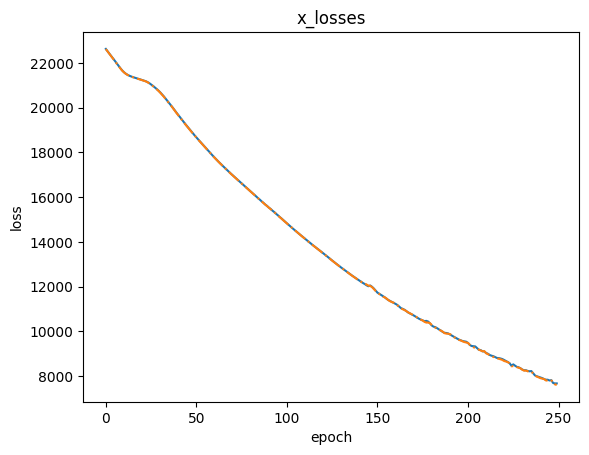

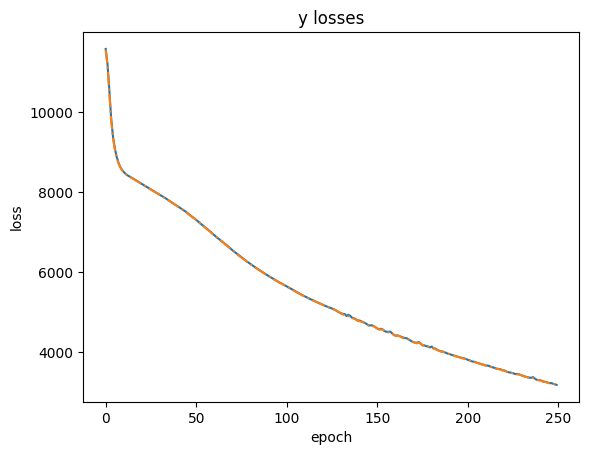

In [16]:
plt.plot(losses_x)
plt.plot( losses_val_x, '-.')

plt.xlabel("epoch")
plt.ylabel("loss")
plt.title('x_losses')
plt.show()

plt.plot(losses_y)
plt.plot(losses_val_y, '-.')

plt.xlabel("epoch")
plt.ylabel("loss")
plt.title('y losses')
plt.show()





# with torch.no_grad():
#     correct = 0
#     total = 0
#     for i, (labels, images) in enumerate(processed_data):
#         images = images.reshape((1, 4, 60, 80))
#         images = images.to(device)
#         labels = torch.tensor(labels, dtype=torch.float32)
#         labels = labels.to(device)
#         outputs = model(images)
#         print([labels[0], labels[1]], [outputs[0], outputs[1]])


